In [1]:
import yfinance
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

<AxesSubplot:xlabel='Date'>

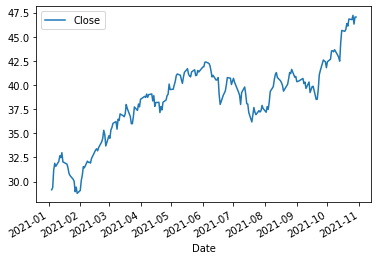

In [3]:
# RMSE CALCULATION
def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt(np.mean(diffs**2))

# Get data
bac_ticker = yfinance.Ticker('BAC')
bac_frame = bac_ticker.history(period='id', start='2021-01-01', end='2021-10-30')['Close'].to_frame()
bac_frame.plot()

AR Coeffs: [0.008733745758047196, 0.057692856313614094, -0.11426659346579937, 0.016393794554558028, 1.0333229740401073]
Standard Deviation:  0.5961484073633104
(100, 110)


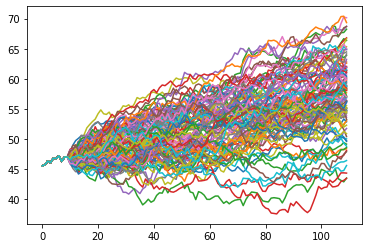

In [7]:
def monte_carlo_sim(df, col, p, num_samples, trajectory_length):
    # create AR model
    model = sm.tsa.AutoReg(df[col].reset_index()[col], p, trend='n').fit()
    
    # get AR coeffs
    coeffs = list(reversed(model.params))
    print('AR Coeffs:', coeffs)

    # calc standard deviation from predictions
    std_dev = rmse(model.predict(), df[col].reset_index()[col])
    print('Standard Deviation: ',std_dev)

    # get initial values, last 10 values
    initial_values = np.array(df[col][-10:]).reshape(1,-1)
    # print(initial_values)

    # create start of trajectories - all start with same init values
    # COLUMNS will be the number of init values
    # ROWS number of samples/trajectories 
    values = np.broadcast_to(initial_values, (num_samples, 10))
    # print('VALUES: ',values)

    # iterate each step for total trajectory length
    for i in range(trajectory_length):
        # next pred = last p values * AR(p) coefficients
        next_prediction = values[:,-p:] @ coeffs
        # next column
        next_column = next_prediction + std_dev * np.random.randn(num_samples)
        values = np.append(values, next_column.reshape(num_samples, 1), axis=1)
    print(values.shape)
    # print('NEW VALUES: ', values)
    _=plt.plot(values.transpose())
    
    return values, next_column


bac_vals, bac_next_col = monte_carlo_sim(bac_frame, 'Close', 5, 100, 100)




In [9]:
def prob_above(values, marker):
    count = np.count_nonzero((values > marker))
    return count/values.size

def prob_below(values, marker):
    count = np.count_nonzero((values < marker))
    return count/values.size

def prob_between(values, low, high):
    count_low = np.count_nonzero((values < low))
    count_high = np.count_nonzero((values > high))
    return (values.size - count_low - count_high) / values.size


print(prob_above(bac_next_col, 50))
print(prob_below(bac_next_col, 45))
print(prob_between(bac_next_col, 45, 50))

0.87
0.03
0.1
